In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Local imports
from qml.models.multiclass import HybridQuantumMultiClassCNN, BatchedGPUHybridQuantumMultiClassCNN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Fashion MNIST images are 28x28
IMAGE_SIZE = 28  
# Set to an int (e.g., 1000) for quick validation, None for full dataset
LIMIT_SAMPLES = None  

# Transform for Fashion MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Fashion MNIST normalization
])

# Load Fashion MNIST dataset
train_dataset_full = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset_full = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

# Limit dataset size if specified
if LIMIT_SAMPLES is not None:
    train_dataset = Subset(train_dataset_full, range(min(LIMIT_SAMPLES, len(train_dataset_full))))
    test_dataset = Subset(test_dataset_full, range(min(LIMIT_SAMPLES // 5, len(test_dataset_full))))
else:
    train_dataset = train_dataset_full
    test_dataset = test_dataset_full

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Image shape: {train_dataset_full[0][0].shape}")
print(f"Number of classes: {len(train_dataset_full.classes)}")

Training images: 60000
Test images: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [4]:
# DataLoader configuration
BATCH_SIZE = 32

# Create data loaders from the pre-split datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

Train batches: 1875
Test batches: 313
Batch size: 32


## Create Quantum CNN Model

In [5]:
# Model configuration
from qml.ansatz.dense import DenseQCNNAnsatz

# Select appropriate model class based on device
if device.type == 'cuda':
    print("Selecting BatchedGPUHybridQuantumMultiClassCNN for CUDA acceleration")
    ModelClass = BatchedGPUHybridQuantumMultiClassCNN
else:
    print("Selecting standard HybridQuantumMultiClassCNN")
    ModelClass = HybridQuantumMultiClassCNN

model = ModelClass(
    num_classes=10,
    kernel_size=3,
    stride=1,
    pool_size=20,
    encoding='dense',
    ansatz=DenseQCNNAnsatz(),
    measurement='z',
    hidden_size=128
)

model = model.to(device)
print(f"Model output classes: {model.num_classes}")
print(f"Quantum Layer Type: {type(model.qconv).__name__}")

Selecting BatchedGPUHybridQuantumMultiClassCNN for CUDA acceleration
Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliZ
Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliZ
Model output classes: 10
Quantum Layer Type: BatchedGPUQuantumConv2D


## Setup Training

In [6]:
from notebooks.utils import print_model_parameters

# Display model parameter count
print_model_parameters(model)


MODEL PARAMETER COUNT
Total parameters:                52,648
Trainable parameters:            52,648
Non-trainable parameters:             0

Parameter breakdown by layer:
Layer                                    Parameters      Trainable 
-----------------------------------------------------------------
qconv.q_params                           30              Yes       
classical.1.weight                       51,200          Yes       
classical.1.bias                         128             Yes       
classical.4.weight                       1,280           Yes       
classical.4.bias                         10              Yes       


In [7]:
from notebooks.multiclass_trainer import MultiClassTrainer

# Training configuration
LEARNING_RATE = 0.005
EPOCHS = 15

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = MultiClassTrainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [8]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.85it/s]


Epoch 1: Train Loss=0.6220, Train Acc=0.7670 | Test Loss=0.5129, Test Acc=0.8142


Evaluating: 100%|██████████| 313/313 [01:51<00:00,  2.81it/s]


Epoch 2: Train Loss=0.5080, Train Acc=0.8119 | Test Loss=0.4861, Test Acc=0.8213


Evaluating: 100%|██████████| 313/313 [01:47<00:00,  2.91it/s]


Epoch 3: Train Loss=0.4837, Train Acc=0.8211 | Test Loss=0.4710, Test Acc=0.8208


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Epoch 4: Train Loss=0.4786, Train Acc=0.8228 | Test Loss=0.4974, Test Acc=0.8138


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.85it/s]


Epoch 5: Train Loss=0.4719, Train Acc=0.8258 | Test Loss=0.4610, Test Acc=0.8348


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Epoch 6: Train Loss=0.4704, Train Acc=0.8262 | Test Loss=0.4631, Test Acc=0.8304


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Epoch 7: Train Loss=0.4711, Train Acc=0.8266 | Test Loss=0.4662, Test Acc=0.8302


Evaluating: 100%|██████████| 313/313 [01:47<00:00,  2.90it/s]


Epoch 8: Train Loss=0.4704, Train Acc=0.8257 | Test Loss=0.4717, Test Acc=0.8246


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 9: Train Loss=0.4688, Train Acc=0.8269 | Test Loss=0.4631, Test Acc=0.8303


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 10: Train Loss=0.4663, Train Acc=0.8283 | Test Loss=0.4519, Test Acc=0.8363


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


Epoch 11: Train Loss=0.4672, Train Acc=0.8268 | Test Loss=0.4600, Test Acc=0.8332


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.85it/s]


Epoch 12: Train Loss=0.4670, Train Acc=0.8279 | Test Loss=0.4934, Test Acc=0.8256


Evaluating: 100%|██████████| 313/313 [01:47<00:00,  2.90it/s]


Epoch 13: Train Loss=0.4631, Train Acc=0.8304 | Test Loss=0.4458, Test Acc=0.8361


Evaluating: 100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epoch 14: Train Loss=0.4685, Train Acc=0.8271 | Test Loss=0.4775, Test Acc=0.8234


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.87it/s]

Epoch 15: Train Loss=0.4670, Train Acc=0.8289 | Test Loss=0.4547, Test Acc=0.8292


## Train results

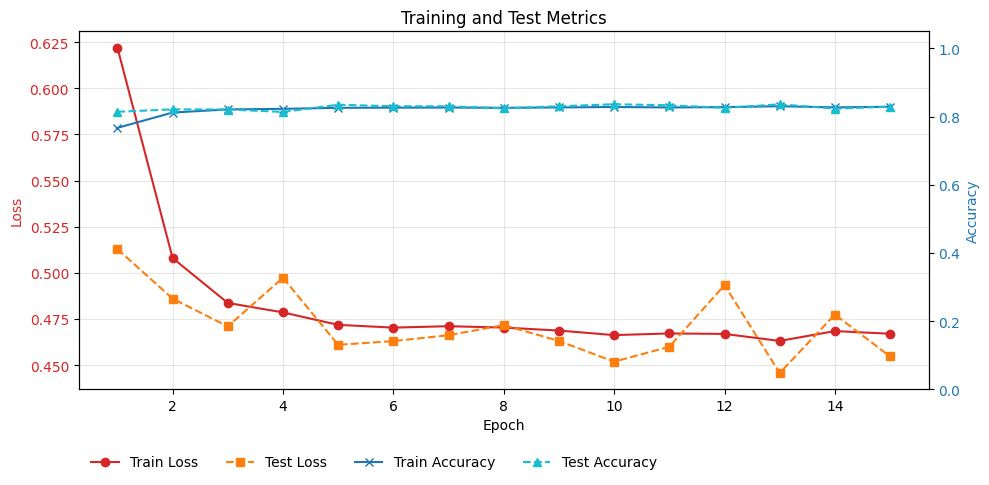

In [9]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.85it/s]



Final Test Results:
Test Loss: 0.4547
Test Accuracy: 0.8292


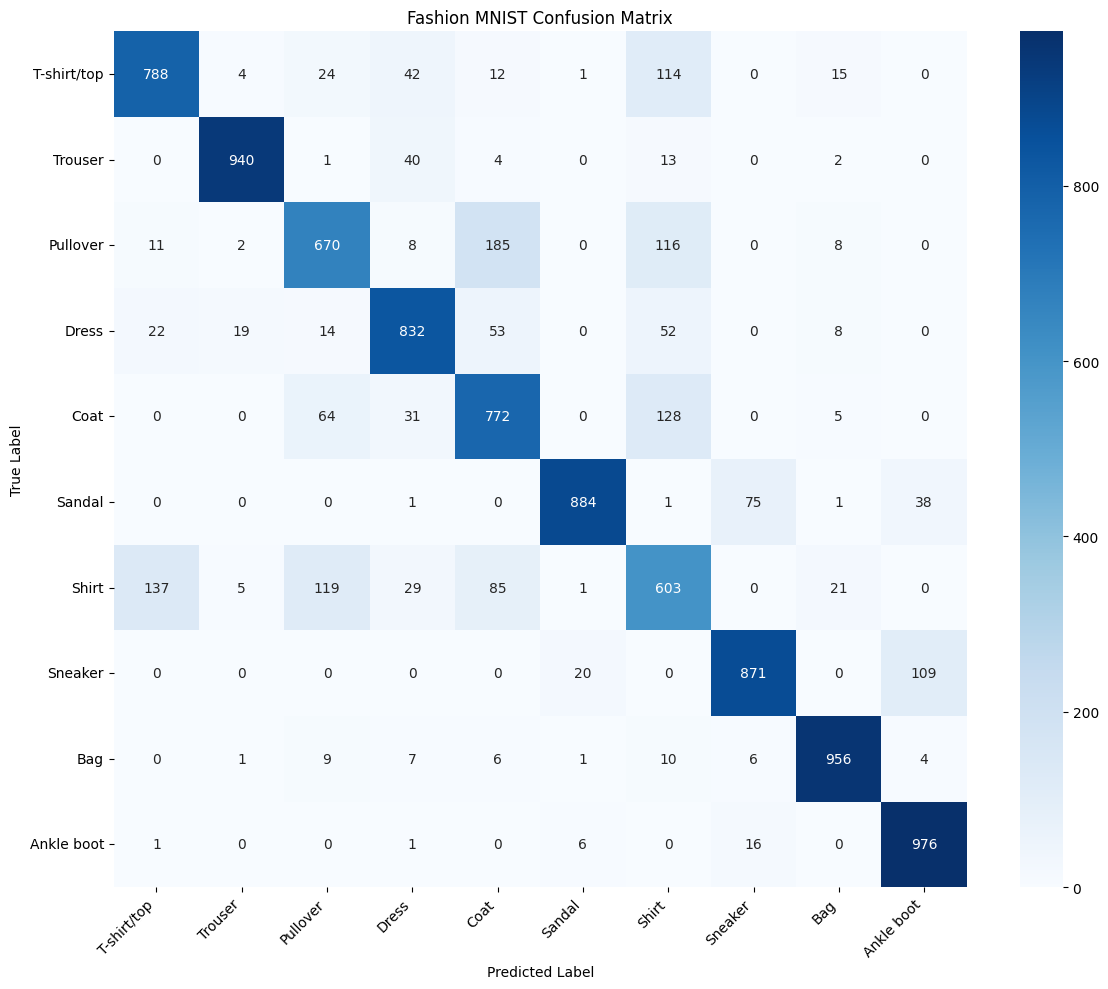


Per-Class Metrics:
Class           Precision    Recall       F1-Score    
-------------------------------------------------------
T-shirt/top     0.8217       0.7880       0.8045      
Trouser         0.9681       0.9400       0.9538      
Pullover        0.7436       0.6700       0.7049      
Dress           0.8396       0.8320       0.8358      
Coat            0.6911       0.7720       0.7293      
Sandal          0.9682       0.8840       0.9242      
Shirt           0.5815       0.6030       0.5920      
Sneaker         0.8998       0.8710       0.8852      
Bag             0.9409       0.9560       0.9484      
Ankle boot      0.8660       0.9760       0.9177      

Overall Accuracy: 0.8292


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix for 10 classes
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Fashion MNIST Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print(f"\nPer-Class Metrics:")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 55)

for i in range(10):
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_names[i]:<15} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

# Overall metrics
total_correct = np.trace(confusion_matrix)
total_samples = confusion_matrix.sum()
print(f"\nOverall Accuracy: {total_correct / total_samples:.4f}")